## Forecasting climate change using ARIMA

This notebook will use Autoregressive Integrated Moving Average (ARIMA) based models to forecast global or local temperatures measured across the globe.

ARIMA is a forecasting method for univariate time series data which combines autoregressive and moving average elements. Additionally it accounts for time series with trends by taking into account differencing.

An ARIMA model is characterised by three parameters:

- **p**: Order of the autoregressive component (the data can be explained partly by previous data points, so this is the number of lag observations to include)
- **d**: Order of the difference (how often the data needs to be differenced in order for the series to become stationary)
- **q**: Order of the moving average (the data can be explained by a moving average model, so this is the size of the moving average window)


### Table of Contents <a class="anchor" id="toc"></a>

0. [Loading the data](#loading)
1. [Preprocessing](#preprocessing)
2. [Stationarity](#stationarity)
3. [Autocorrelation](#autocorrelation)
4. [Model selection though information criteria](#ic)
5. [Model selection though backtests](#backtests)
6. [Forecasting](#forecast)
7. [Create a benchmark](#benchmark)
8. [Compare model to benchmark](#compare)
9. [Possible further investigations](#future)

### House keeping: importing packages

In [1]:
import itertools as it
import os
from typing import Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import (mean_absolute_error,
                             mean_absolute_percentage_error,
                             mean_squared_error)
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

In [2]:
import warnings
warnings.filterwarnings("ignore")

<br>
<br>

### 0. Load and plot the raw data <a class="anchor" id="loading"></a>

[back to top](#toc)

In [3]:
# parameters to choose which file should be loaded
data_path = "/Users/ph/Documents/ds_projects/climate_change/data"

# global temperatures
filename = "GlobalTemperatures"
col_name_T = "LandAverageTemperature"
col_name_T_uncertainty = "LandAverageTemperatureUncertainty"
col_name_date = "dt"

# city specific temperatures: options: ["Berlin", "Bogota", "Jakarta", "Nairobi", "LA"]
# city_name = "LA"
# filename = "GlobalLandTemperatures" + city_name
# col_name_T = "AverageTemperature"
# col_name_T_uncertainty = "AverageTemperatureUncertainty"
# col_name_date = "dt"


In [4]:
def load_csv_file(filename: str, date_column: str):
    print(f"loading {filename}")
    df = pd.read_csv(os.path.join(data_path, f"{filename}.csv"))
    df[date_column] = pd.to_datetime(df[date_column])
    df = df.set_index(date_column)
    return df

In [5]:
temperature = load_csv_file(filename, col_name_date)
temperature

loading GlobalTemperatures


,LandAverageTemperature,LandAverageTemperatureUncertainty,LandMaxTemperature,LandMaxTemperatureUncertainty,LandMinTemperature,LandMinTemperatureUncertainty,LandAndOceanAverageTemperature,LandAndOceanAverageTemperatureUncertainty
dt,,,,,,,,
1750-01-01,3.034,3.574,NaN,NaN,NaN,NaN,NaN,NaN
1750-02-01,3.083,3.702,NaN,NaN,NaN,NaN,NaN,NaN
1750-03-01,5.626,3.076,NaN,NaN,NaN,NaN,NaN,NaN
1750-04-01,8.490,2.451,NaN,NaN,NaN,NaN,NaN,NaN
1750-05-01,11.573,2.072,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2015-08-01,14.755,0.072,20.699,0.110,9.005,0.170,17.589,0.057
2015-09-01,12.999,0.079,18.845,0.088,7.199,0.229,17.049,0.058
2015-10-01,10.801,0.102,16.450,0.059,5.232,0.115,16.290,0.062


<br>
<br>

### 1. Preprocessing <a class="anchor" id="preprocessing"></a>

resample the daily data to yearly and monthly + plot it


In [7]:
avg_temp_per_year = temperature.resample(rule="Y").mean()
avg_temp_per_month = temperature.resample(rule="M").mean()

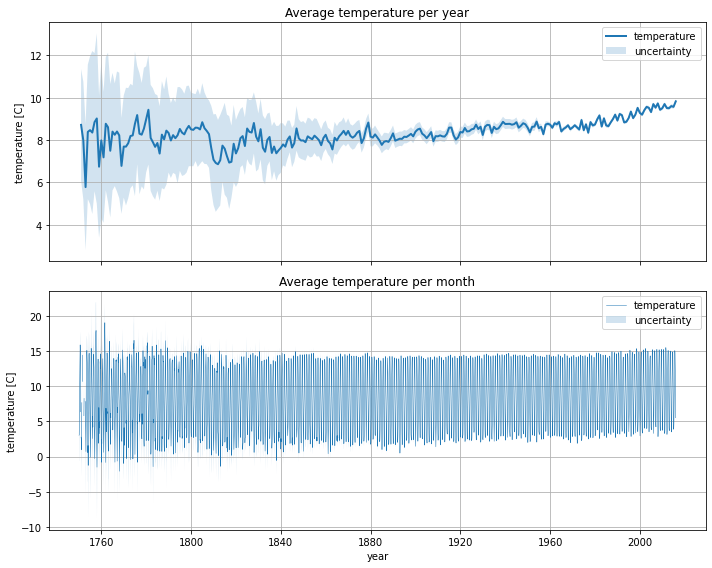

In [8]:
fig, ax = plt.subplots(2, 1, figsize=(10, 8), sharex=True, sharey=False)

# plot avg temperature per year
ax[0].fill_between(
    avg_temp_per_year.index,
    avg_temp_per_year[col_name_T]
    - avg_temp_per_year[col_name_T_uncertainty],
    avg_temp_per_year[col_name_T]
    + avg_temp_per_year[col_name_T_uncertainty],
    alpha=0.2,
    label="uncertainty",
)
ax[0].plot(
    avg_temp_per_year.index,
    avg_temp_per_year[col_name_T],
    linestyle="-",
    linewidth=2,
    label="temperature",
)
ax[0].set_title("Average temperature per year")
# plot avg temperature per month
ax[1].fill_between(
    avg_temp_per_month.index,
    avg_temp_per_month[col_name_T]
    - avg_temp_per_month[col_name_T_uncertainty],
    avg_temp_per_month[col_name_T]
    + avg_temp_per_month[col_name_T_uncertainty],
    alpha=0.2,
    label="uncertainty",
)
ax[1].plot(
    avg_temp_per_month.index,
    avg_temp_per_month[col_name_T],
    linestyle="-",
    linewidth=0.5,
    label="temperature",
)
ax[1].set_xlabel("year")
ax[1].set_title("Average temperature per month")

for ax_idx in range(len(ax)):
    ax[ax_idx].set_ylabel("temperature [C]")
    ax[ax_idx].grid(True)
    ax[ax_idx].legend()
plt.tight_layout()
plt.show()

#### __Conclusion__

[for global temperatures]

__yearly data__:
- seasonal and random fluctuations change as time goes on (more fluctuations at earlier times) therefore it might be wise to only use part of the time series when the fluctuations are relatively stable e.g. only use data from ca 1850 onwards
- there is a upwards trend in the time series (drift) 

__monthly data__:
- seasonal and random fluctuations do not change a lot as time goes on
- very strong seasonal effect --> should probably use SARIMA or something similar


--> As a first step, I would like to keep it simple and forecast the yearly temperatures. An ARIMA model should work well


In [9]:
avg_temp_per_year = avg_temp_per_year[avg_temp_per_year.index.year >= 1850]

<br>
<br>

### 2. Stationarity <a class="anchor" id="stationarity"></a>

[back to top](#toc)

Because ARIMA includes linear regression, and linear regression does not work with non-stationary data, is needs to be possible to convert the data into a stationary signal by differencing (removed drift and seasonal components)

In [10]:
def run_adf_test(df: pd.DataFrame, column: str):
    result = adfuller(df[column], autolag="AIC")
    p_value = result[1]
    print(f"    p = {p_value:.4f}")
    if p_value > 0.05:
        print(
            "    --> we cannot reject the Null Hypothesis -> the time series is non-stationary"
        )
        print("        we will have to differentiate the time series further")
        time_series_is_stationary = False
    else:
        print(
            "        --> we can reject the Null Hypothesis -> the time series is stationary."
        )
        time_series_is_stationary = True
    return time_series_is_stationary

In [11]:
print(f"Null Hypothesis for augmented Dickie Fuller: the time series is non-stationary")
    
print("\nraw time series")
time_series_is_stationary = run_adf_test(avg_temp_per_year, col_name_T)

print("\n1x differenced")
avg_temp_per_year_diff = avg_temp_per_year.diff()
time_series_is_stationary = run_adf_test(
    avg_temp_per_year_diff.dropna(), col_name_T
)

print("\n2x differenced")
avg_temp_per_year_diff_twice = avg_temp_per_year_diff.diff()
time_series_is_stationary = run_adf_test(
    avg_temp_per_year_diff_twice.dropna(), col_name_T
)

Null Hypothesis for augmented Dickie Fuller: the time series is non-stationary

raw time series
    p = 0.9505
    --> we cannot reject the Null Hypothesis -> the time series is non-stationary
        we will have to differentiate the time series further

1x differenced
    p = 0.0000
        --> we can reject the Null Hypothesis -> the time series is stationary.

2x differenced
    p = 0.0000
        --> we can reject the Null Hypothesis -> the time series is stationary.


#### __Conclusion__

[for global temperatures]

we should set the parameter d in the ARIMA model to at least 1 

<br>
<br>


### 3. Autocorrelation <a class="anchor" id="autocorrelation"></a>

[back to top](#toc)

Autocorrelation describes the correlation of a time series with a shifted version of itself e.g. f(t) with f(t-k). This can give us an insight about 

A partial autocorrelation removes the effect of shorter autocorrelation lags when calculating the correlation at longer lags. To be more precise, the partial correlation at lag k is the 
autocorrelation between Yt and Yt-k that is NOT accounted for by the autocorrelations from the 1st to the (k-1)st lags.

Autocorrelation assumes the variables to be distributed normally.

Let's plot the autocorrelation and partial autocorrelation for the **original** values

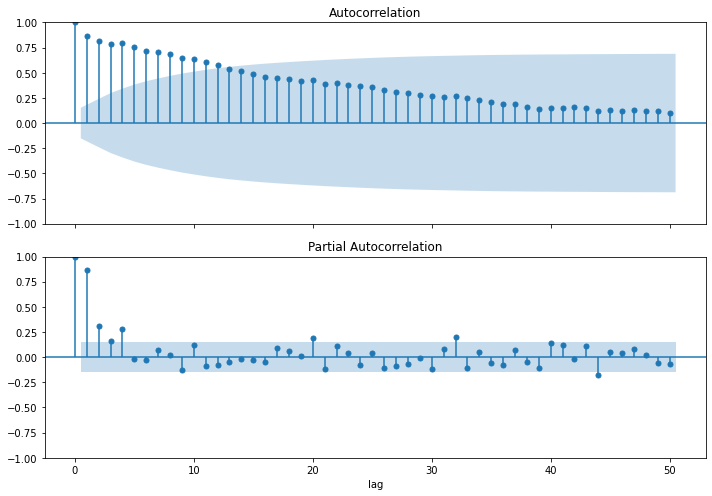

In [12]:
fig, axes = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))
plot_acf(avg_temp_per_year[col_name_T], lags=50, ax=axes[0])
plot_pacf(avg_temp_per_year[col_name_T], lags=50, ax=axes[1])
plt.xlabel("lag")
plt.tight_layout()
plt.show()

#### __Conclusion__

[for global temperatures]

The autocorrelation decays slowly --> sign of a drift.
There are mulitple lags which seem to have a positive autocorrelation, 
so we should explore a few different values for p (the AR order) up to 10.

The partial autocorrelation shows lags 1-3 as potentially influencing the time series, so we should (at least) explore to an AR order of 4.

### 4. Determining ARIMA parameters p, d, q though information criteria (model selection) <a class="anchor" id="ic"></a>

[back to top](#toc)

AIC = Akaike Information Criterion

BIC = Bayesian Information Criterion

In [13]:
p_values_to_try = range(10)
d_values_to_try = range(1, 3)
q_values_to_try = range(5)
p_d_q_combinations = list(it.product(p_values_to_try, d_values_to_try, q_values_to_try))

parameter_results = []
for p, d, q in p_d_q_combinations:
    mod = ARIMA(avg_temp_per_year[col_name_T], order=(p, d, q))
    fitted_model = mod.fit()
    parameter_results.append(
        [
            p,
            d,
            q,
            fitted_model.aic,
            fitted_model.bic,
            fitted_model.mle_retvals["converged"],
        ]
    )

parameter_results = pd.DataFrame(
    data=parameter_results, columns=["p", "d", "q", "aic", "bic", "converged"]
)

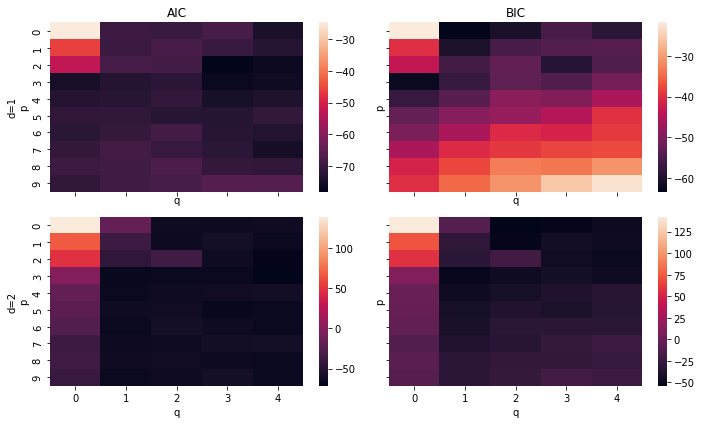

In [14]:
results_d_is_1 = parameter_results[parameter_results["d"] == 1]
results_d_is_2 = parameter_results[parameter_results["d"] == 2]

fig, ax = plt.subplots(2, 2, figsize=(10, 6), sharex=True, sharey=True)
sns.heatmap(results_d_is_1.pivot(values="aic", columns="q", index="p"), ax=ax[0, 0])
sns.heatmap(results_d_is_1.pivot(values="bic", columns="q", index="p"), ax=ax[0, 1])
sns.heatmap(results_d_is_2.pivot(values="aic", columns="q", index="p"), ax=ax[1, 0])
sns.heatmap(results_d_is_2.pivot(values="bic", columns="q", index="p"), ax=ax[1, 1])
ax[0, 0].set_title("AIC")
ax[0, 1].set_title("BIC")
ax[0, 0].set_ylabel("d=1\np")
ax[1, 0].set_ylabel("d=2\np")
plt.tight_layout()
plt.show()

#### __Conclusion__

[for global temperatures]

There does not seem to be an immediate best order for the model.

In this case I decided to look at the predictions made by a model using the different parameters and decide on the best values based on the performance.

<br>
<br>

## 5. Determining ARIMA parameters p, d, q though backtests (model selection) <a class="anchor" id="backtests"></a>

[back to top](#toc)

In order to evaluate model performance, I am running backtests - in essence I am training the model on a shortened time series (which finishes in the past), so that I can compare the predicted values to the true observations (which were not trained on).

I decided to create a number of training + test sets, which I will use for the backtests.

The size of training data set was set to 100 and the size of the test set to 10.<br>
--> this means that the model will use 100 historical data points to predict 10 data points, which I will then compare to the true yearly temperatures in the test set.

The metrics I decided to collect are 

- MSE (mean squared error)

- MASE (mean absolute squared error)

- MAPE (mean absolute percentage error)

In [35]:
NUM_YEARS_FOR_TRAINING = 100
YEARS_TO_FORECAST = 10
NUM_BACKTESTS = (avg_temp_per_year.shape[0] - 100) // YEARS_TO_FORECAST
FIRST_YEAR_IDX = avg_temp_per_year.shape[0] - 100 - YEARS_TO_FORECAST * NUM_BACKTESTS
BACKTEST_START_YEARS = avg_temp_per_year.index[np.arange(FIRST_YEAR_IDX, avg_temp_per_year.shape[0] - NUM_YEARS_FOR_TRAINING, YEARS_TO_FORECAST)].year.values
    
print(f"will run {NUM_BACKTESTS} backtests:")
print(f"each backtest trains a model on {NUM_YEARS_FOR_TRAINING} years of data to predict the following {YEARS_TO_FORECAST} years.")
for start_idx in BACKTEST_START_YEARS:
    end_idx = start_idx + NUM_YEARS_FOR_TRAINING
    print(f"    training data [{start_idx} - {start_idx+NUM_YEARS_FOR_TRAINING-1}], to predict [{end_idx} - {end_idx+YEARS_TO_FORECAST}]")


will run 6 backtests:
each backtest trains a model on 100 years of data to predict the following 10 years.
    training data [1856 - 1955], to predict [1956 - 1966]
    training data [1866 - 1965], to predict [1966 - 1976]
    training data [1876 - 1975], to predict [1976 - 1986]
    training data [1886 - 1985], to predict [1986 - 1996]
    training data [1896 - 1995], to predict [1996 - 2006]
    training data [1906 - 2005], to predict [2006 - 2016]


In [36]:
def run_backtests(series: pd.DataFrame, order: Tuple[int, int, int] = (1, 1, 1)) -> pd.DataFrame:
    # create backtest training and test sets

    result_collection = []

    fig, ax = plt.subplots(1, figsize=(8, 4))
    ax.plot(series, c="k")

    for start_idx in range(
        FIRST_YEAR_IDX, series.shape[0] - NUM_YEARS_FOR_TRAINING, YEARS_TO_FORECAST
    ):
        end_idx = start_idx + NUM_YEARS_FOR_TRAINING
        start_year = series.index[start_idx].year
        start_prediction_year = series.index[end_idx].year
        mod = ARIMA(series.iloc[start_idx:end_idx], order=order)
        fitted_model = mod.fit()

        # Get forecast
        forecast_yearly = fitted_model.get_forecast(
            steps=YEARS_TO_FORECAST
        ).predicted_mean
        # forecast_yearly.index = forecast_yearly.index.rename(avg_temp_per_year.index.name)

        true_temperatures = series[forecast_yearly.index]

        mse = mean_squared_error(forecast_yearly, true_temperatures)
        mase = mean_absolute_error(forecast_yearly, true_temperatures)
        mape = mean_absolute_percentage_error(forecast_yearly, true_temperatures)

        ax.plot(forecast_yearly, c="orange")
        ax.set_title(f"Forecast using {p=} {d=} {q=}")

        result_collection.append(
            [p, d, q, start_year, start_prediction_year, mse, mase, mape]
        )

    result_collection = pd.DataFrame(
        data=result_collection,
        columns=[
            "p",
            "d",
            "q",
            "start_year",
            "start_prediction_year",
            "mse",
            "mase",
            "mape",
        ],
    )

    return result_collection, fig

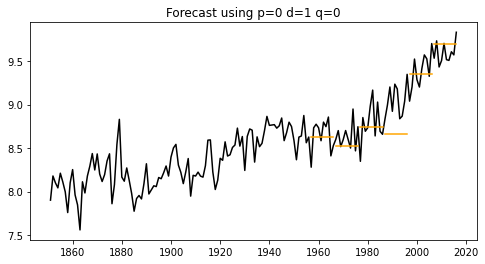

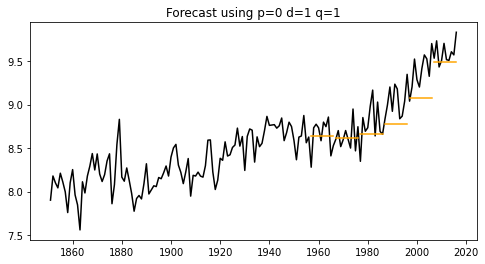

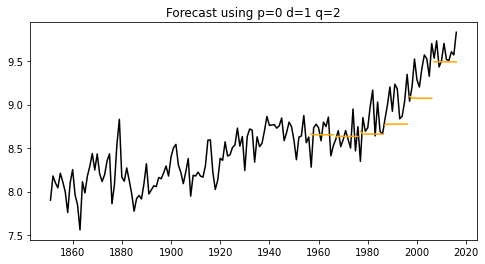

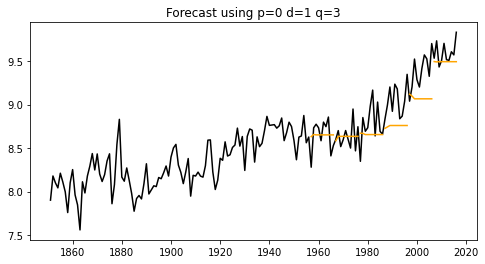

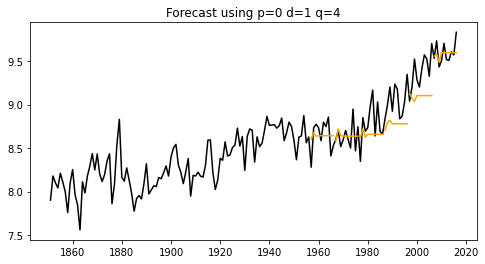

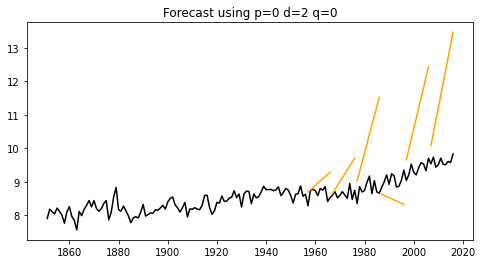

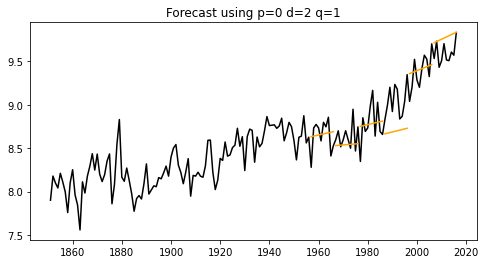

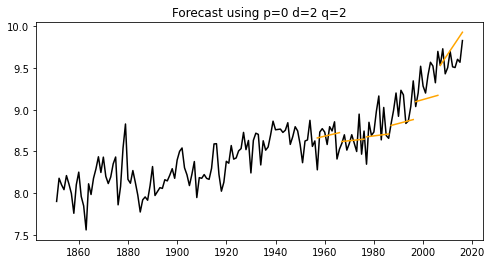

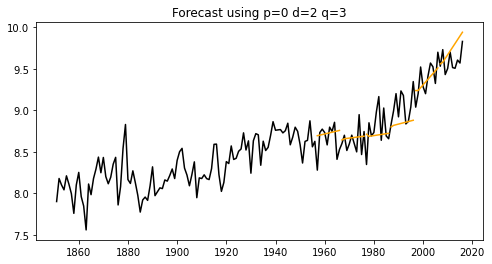

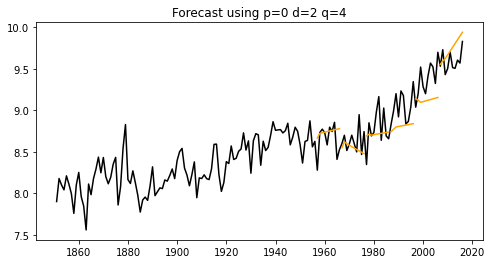

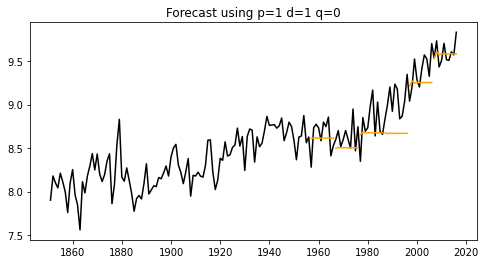

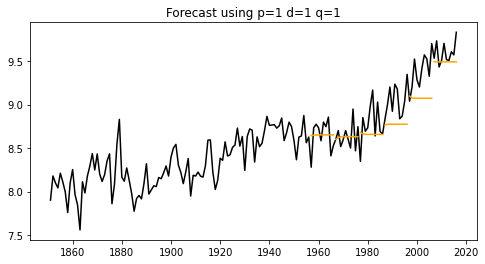

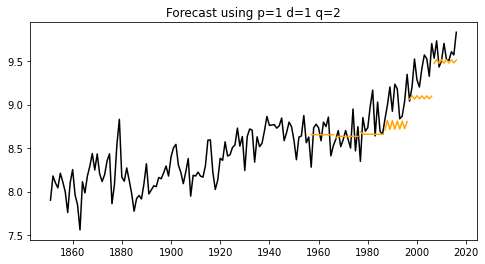

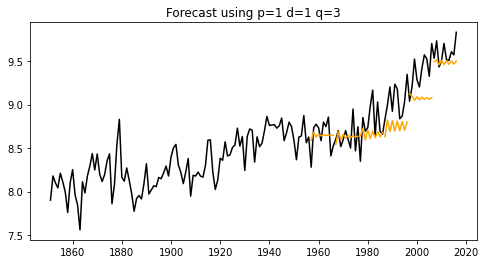

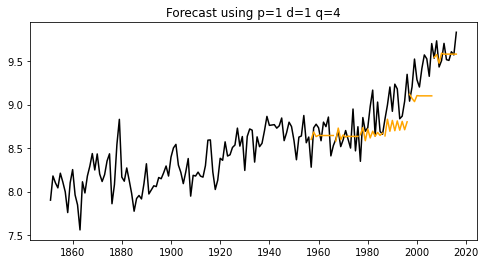

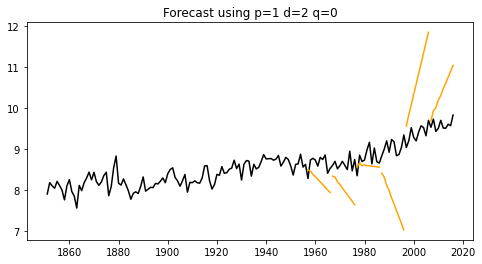

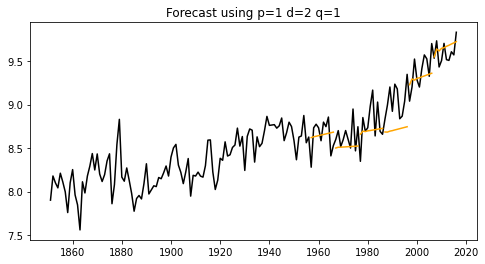

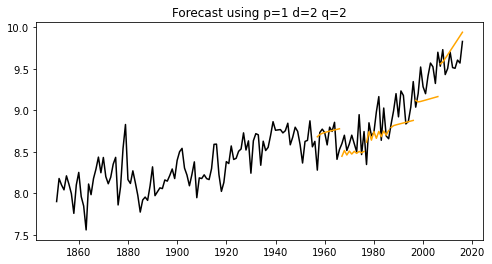

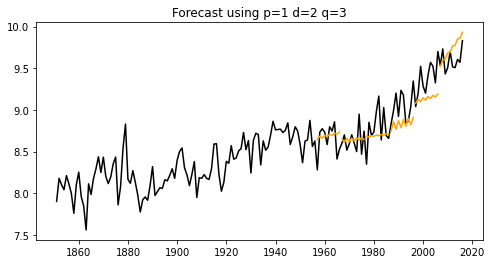

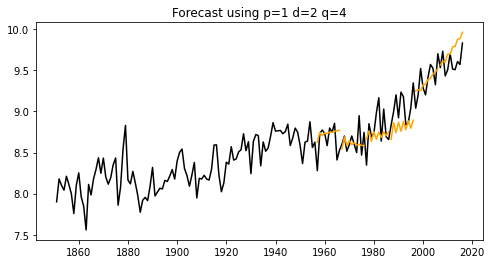

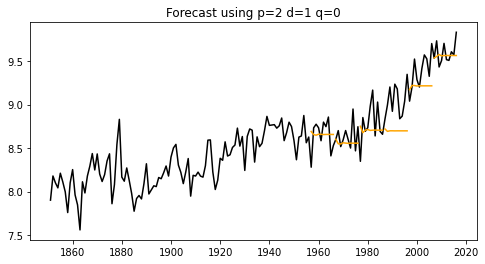

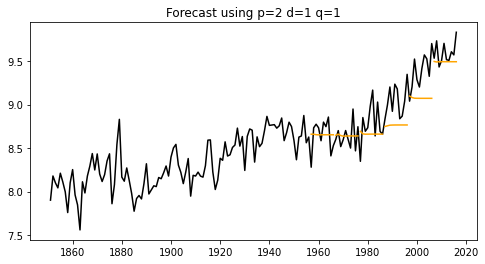

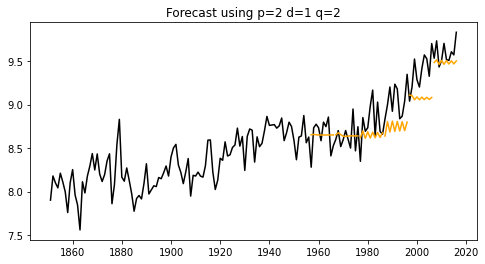

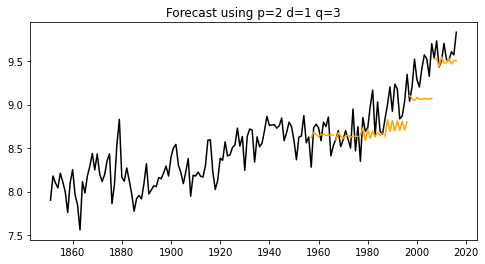

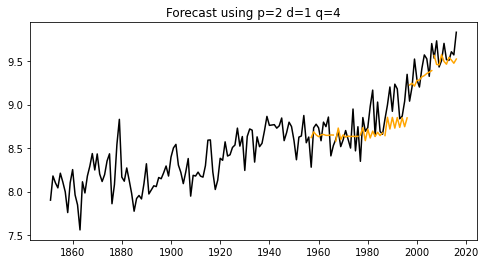

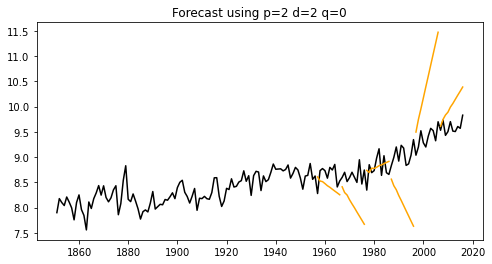

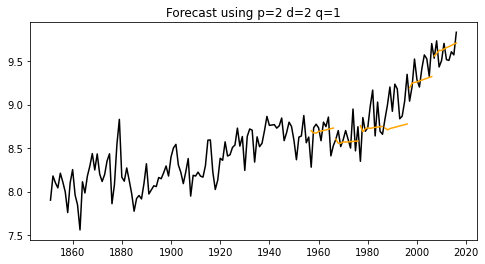

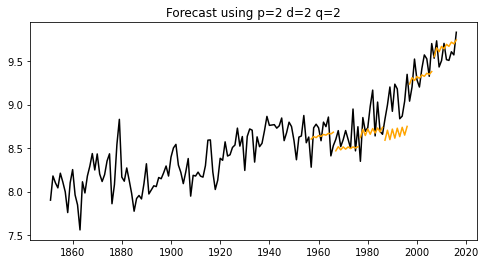

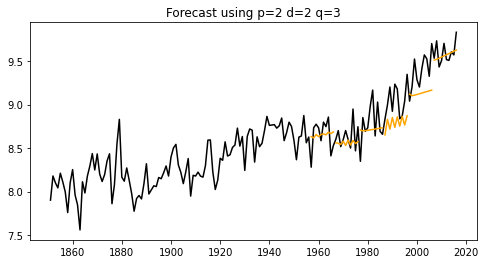

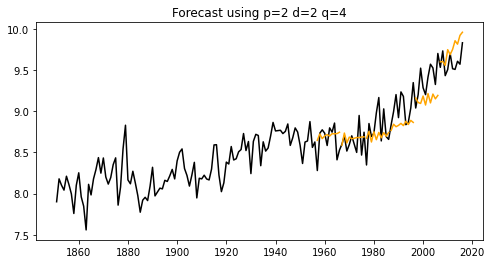

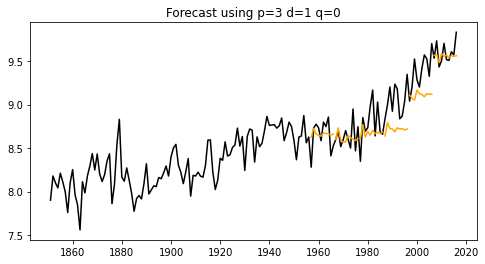

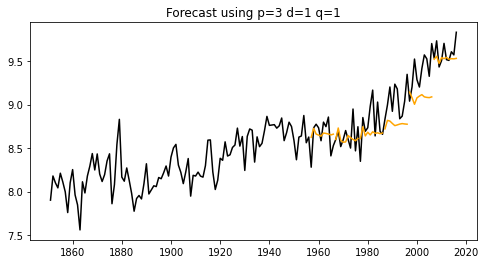

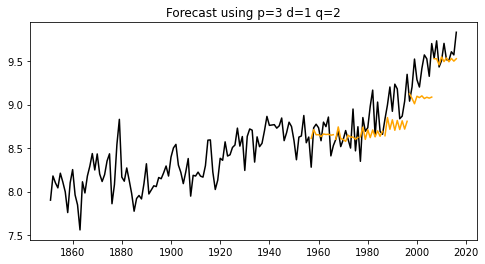

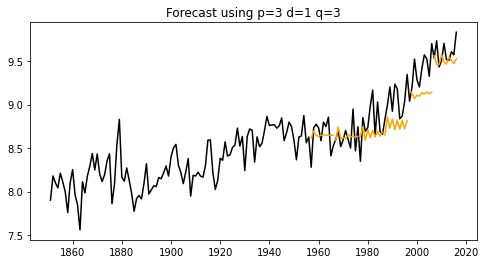

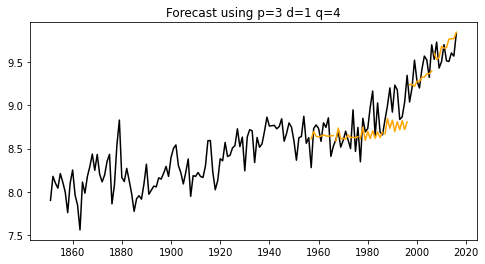

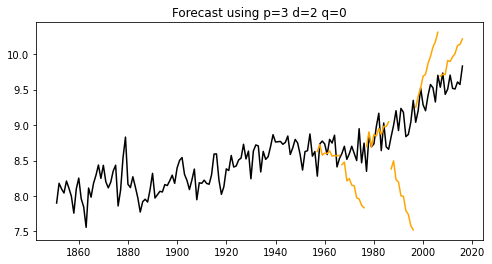

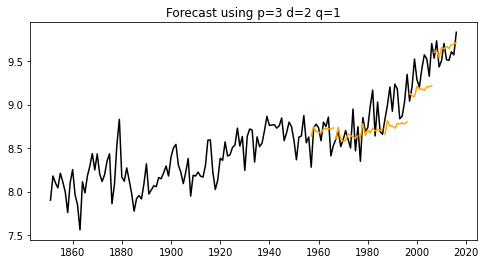

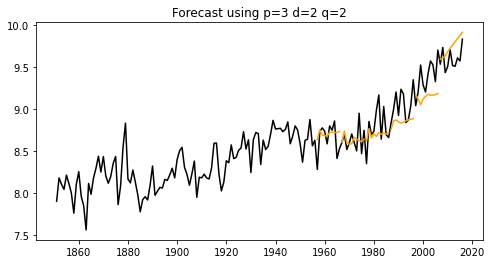

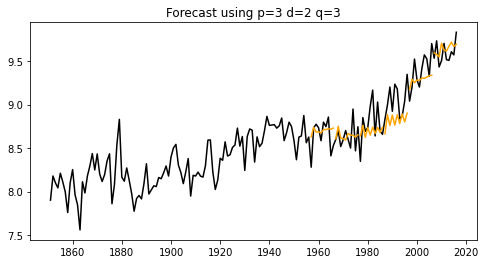

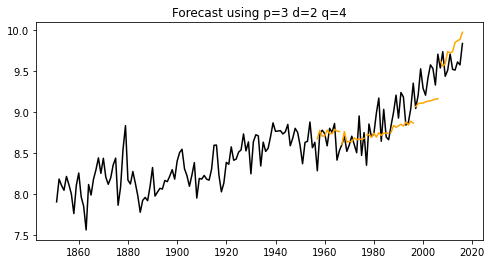

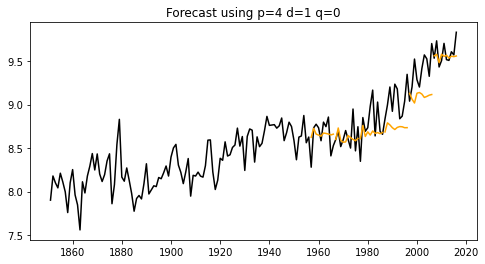

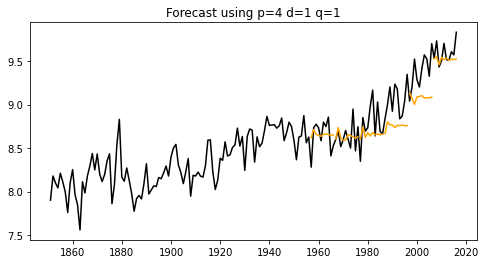

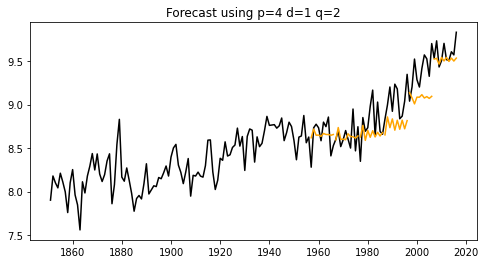

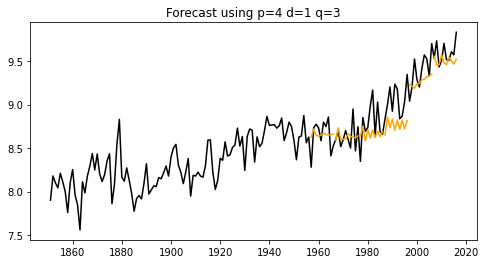

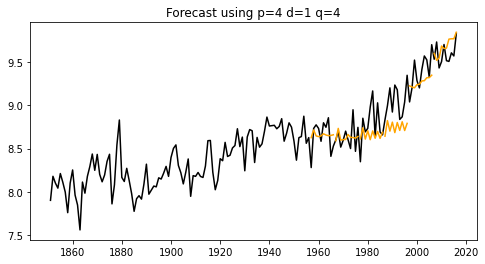

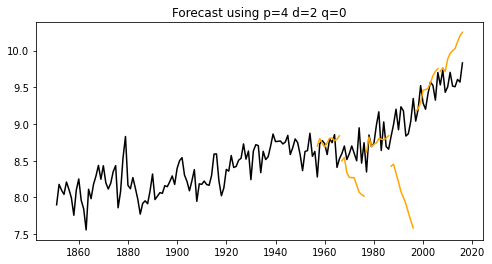

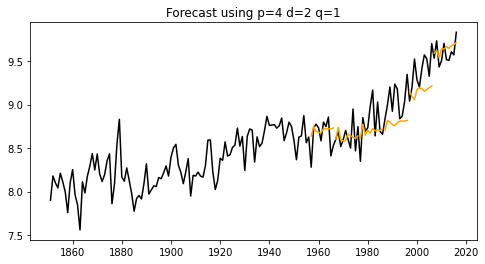

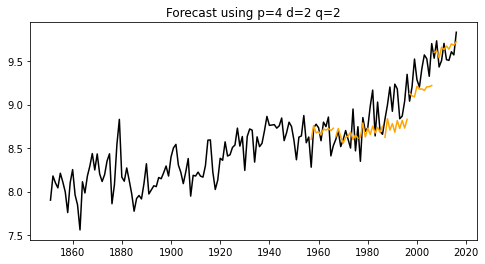

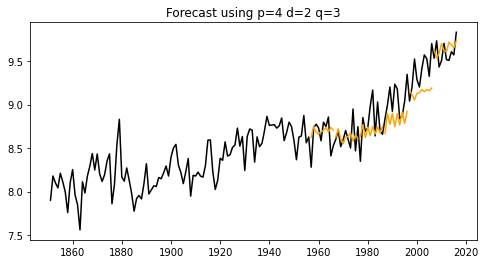

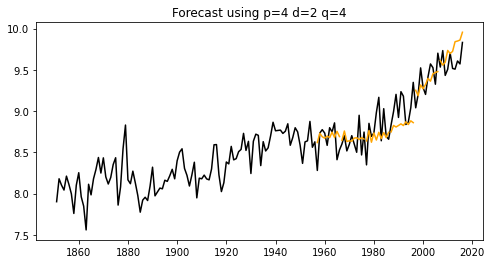

In [37]:
p_values_to_backtest = range(5)
d_values_to_backtest = range(1, 3)
q_values_to_backtest = range(5)
p_d_q_combinations = list(it.product(p_values_to_backtest, d_values_to_backtest, q_values_to_backtest))

backtest_results = []
for p, d, q in p_d_q_combinations:
    backtest_results_temp, fig = run_backtests(
        series=avg_temp_per_year[col_name_T], order=(p, d, q)
    )
    backtest_results.append(backtest_results_temp)

backtest_results = pd.concat(backtest_results)


In [41]:
backtest_results.head(10).set_index(["p", "d", "q"])

start_year  start_prediction_year       mse      mase      mape
p d q                                                                 
0 1 0        1856                   1956  0.031952  0.158558  0.018381
    0        1866                   1966  0.030369  0.129467  0.015182
    0        1876                   1976  0.050652  0.175183  0.020033
    0        1886                   1986  0.180823  0.387417  0.044747
    0        1896                   1996  0.038381  0.168183  0.017993
    0        1906                   2006  0.025455  0.139992  0.014431
    1        1856                   1956  0.031642  0.155271  0.017966
    1        1866                   1966  0.018889  0.104413  0.012122
    1        1876                   1976  0.062938  0.184696  0.021321
    1        1886                   1986  0.102943  0.268722  0.030618

In [38]:
mean_performance_per_order = (
    backtest_results.groupby(by=["p", "d", "q"]).mean().sort_values(by="mse").drop(columns=["start_year", "start_prediction_year"])
)
mean_performance_per_order.head(10)

mse      mase      mape
p d q                              
3 2 3  0.038351  0.150978  0.016902
4 2 4  0.039981  0.157903  0.017546
0 2 3  0.040928  0.157268  0.017459
1 2 4  0.041816  0.157817  0.017546
2 1 4  0.044045  0.160341  0.018062
3 1 4  0.045131  0.165621  0.018597
4 1 3  0.046575  0.163859  0.018463
    4  0.048397  0.169892  0.019093
  2 1  0.048427  0.167862  0.018835
2 2 1  0.048444  0.170106  0.019129

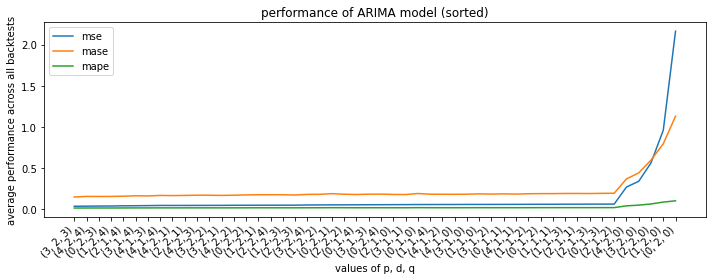

In [39]:
ax = mean_performance_per_order[["mse", "mase", "mape"]].plot(figsize=(10, 4))
ax.set_xticks(range(mean_performance_per_order.shape[0]))
ax.set_xticklabels(mean_performance_per_order.index, rotation=45, ha="right")
ax.set_ylabel("average performance across all backtests")
ax.set_xlabel("values of p, d, q")
ax.set_title("performance of ARIMA model (sorted)")
plt.tight_layout()

#### __Conclusion__

[for global temperatures]

According to the performance of the model on the backtests, 
nearly all models with parameter d set to 2 perform better than models with d set to 1.

Also, a q (MA order) of greater than 0 seems to be beneficial.


The visual inspection confirms that the model with the best performance scores (lowest MSE, MASE, MAPE) seems to create sensible forecasts.

For the actual forecast, the order with the best performance is selected



<br>
<br>

## 6. Forecast temperatures using ARIMA <a class="anchor" id="forecast"></a>

[back to top](#toc)

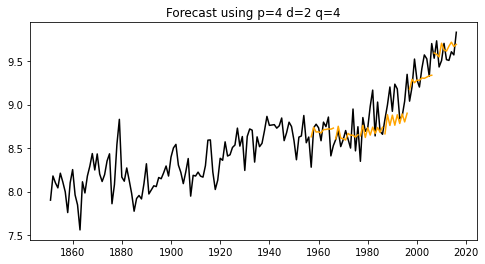

In [42]:
# select the best performing order from before and run the backtests again
best_performing_order = mean_performance_per_order.index[0]
best_performing_backtest_result, fig = run_backtests(
    series=avg_temp_per_year[col_name_T], order=best_performing_order
)


In [43]:
# create the model
mod = ARIMA(avg_temp_per_year[col_name_T], order=best_performing_order)
fitted_model = mod.fit()

# create the forecast
forecast_yearly = fitted_model.get_forecast(steps=YEARS_TO_FORECAST)
forecast_yearly_ci = forecast_yearly.conf_int()

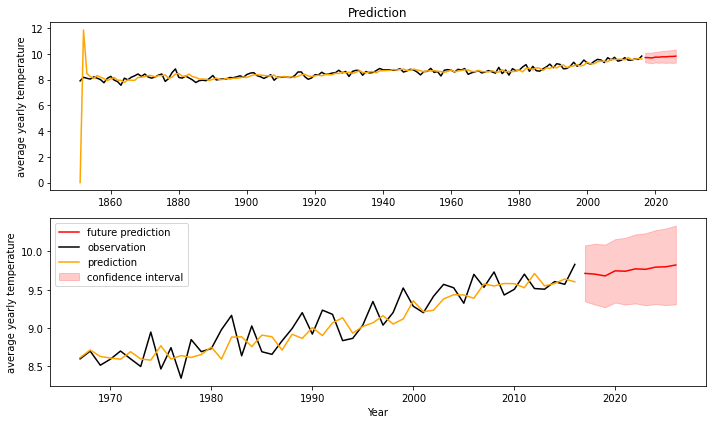

In [44]:
fig, ax = plt.subplots(2, 1, figsize=(10, 6))
ax[0].plot(forecast_yearly.predicted_mean, color="r", label="future prediction")
ax[0].fill_between(
    forecast_yearly.row_labels,
    forecast_yearly_ci.iloc[:, 0],
    forecast_yearly_ci.iloc[:, 1],
    color="r",
    alpha=0.2,
    label="confidence interval",
)
ax[0].plot(avg_temp_per_year[col_name_T], color="k", label="observation")
ax[0].plot(fitted_model.predict(), color="orange", label="prediction")
ax[0].set_ylabel("average yearly temperature")
ax[0].set_title("Prediction")

ax[1].plot(forecast_yearly.predicted_mean, color="r", label="future prediction")
ax[1].fill_between(
    forecast_yearly.row_labels,
    forecast_yearly_ci.iloc[:, 0],
    forecast_yearly_ci.iloc[:, 1],
    color="r",
    alpha=0.2,
    label="confidence interval",
)
ax[1].plot(
    avg_temp_per_year[col_name_T][-YEARS_TO_FORECAST * 5 :],
    color="k",
    label="observation",
)
ax[1].plot(
    fitted_model.predict()[-YEARS_TO_FORECAST * 5 :], color="orange", label="prediction"
)
ax[1].set_xlabel("Year")
ax[1].set_ylabel("average yearly temperature")

plt.legend()
plt.tight_layout()
plt.show()

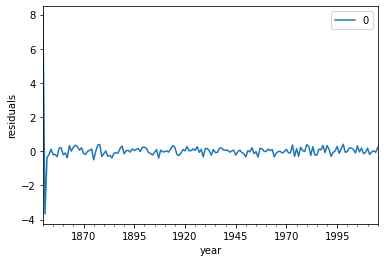

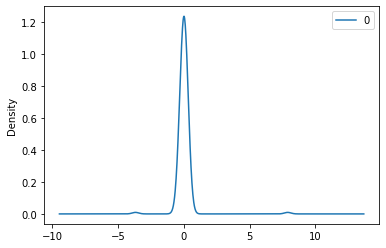

                0
count  166.000000
mean     0.032959
std      0.703705
min     -3.672417
25%     -0.112781
50%      0.013534
75%      0.149474
max      7.900667


In [45]:
# line plot of residuals
residuals = pd.DataFrame(fitted_model.resid)

residuals.plot()
plt.xlabel("year")
plt.ylabel("residuals")
plt.show()
# density plot of residuals
residuals.plot(kind="kde")
plt.show()
# summary stats of residuals
print(residuals.describe())

#### __Conclusion__

[for global temperatures]

Visually the forecast makes sense.

According to the residuals, there is low bias in the model since the mean is close to 0.

Although the residuals are much higher at the start of the time series, potentially hinting at problems in the data during the early data point. 
--> It might be interesting to cut off more of the time series from the beginning.

<br>
<br>

## 7. Create a benchmark <a class="anchor" id="benchmark"></a>

[back to top](#toc)

Everytime we create a model, we should benchmark it not only to itself 
(e.g. other parameter combinations), but entirely other models as well.

Especially in forecasting, any ML model should be compared to the simplest forecastnig models available e.g. 
- a flat line with the value of the median of the past x data points
- a flat line with the value of the last data point in the time series
- (if data is seasonal) the values of the last cycle (e.g. last year for monthly data)



In [46]:
def benchmark_backtests(
    series: pd.DataFrame, backtest_results: pd.DataFrame, num_years_for_benchmark: int
) -> pd.DataFrame:

    start_prediction_year_list = backtest_results["start_prediction_year"].unique()
    result_collection = []

    fig, ax = plt.subplots(1, figsize=(8, 4))
    ax.plot(series, c="k")

    for start_prediction_year in start_prediction_year_list:

        benchmark_mask = (
            series.index.year >= start_prediction_year - num_years_for_benchmark
        ) & (series.index.year < start_prediction_year)
        benchmark_prediction = np.array(
            [np.median(series[benchmark_mask])] * YEARS_TO_FORECAST
        )

        true_values_mask = (series.index.year >= start_prediction_year) & (
            series.index.year < start_prediction_year + YEARS_TO_FORECAST
        )
        true_temperatures = series[true_values_mask]

        mse = mean_squared_error(benchmark_prediction, true_temperatures)
        mase = mean_absolute_error(benchmark_prediction, true_temperatures)
        mape = mean_absolute_percentage_error(benchmark_prediction, true_temperatures)

        ax.plot(series.index[true_values_mask], benchmark_prediction, c="orange")
        ax.set_title(
            f"Benchmark forecast: median of latest {num_years_for_benchmark} years"
        )

        result_collection.append([start_prediction_year, mse, mase, mape])

    result_collection = pd.DataFrame(
        data=result_collection, columns=["start_prediction_year", "mse", "mase", "mape"]
    )

    return result_collection, fig

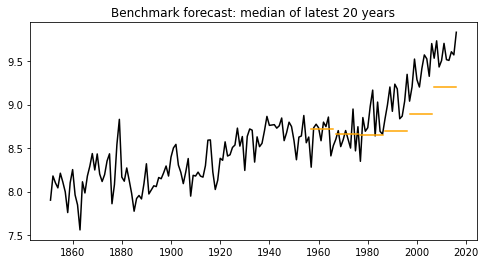

In [47]:
# benchmark: median of the last 20 year
num_years_for_benchmark = 2 * YEARS_TO_FORECAST
backtest_benchmark_results, fig = benchmark_backtests(
    series=avg_temp_per_year[col_name_T],
    backtest_results=backtest_results,
    num_years_for_benchmark=num_years_for_benchmark,
)

#### __Conclusion__

[for global temperatures]

The benchmark seems to do well on earlier backtests, but not so much on the later ones.

<br>
<br>

## 8. Compare against the benchmark <a class="anchor" id="compare"></a>

[back to top](#toc)

In [48]:
# compare performance against benchmark
best_performing_backtest_result = best_performing_backtest_result.set_index(
    "start_prediction_year"
)
backtest_benchmark_results = backtest_benchmark_results.set_index(
    "start_prediction_year"
)
performance_comparison = best_performing_backtest_result.join(
    backtest_benchmark_results, how="left", rsuffix="_benchmark"
).drop(columns=["p", "d", "q", "start_year"])

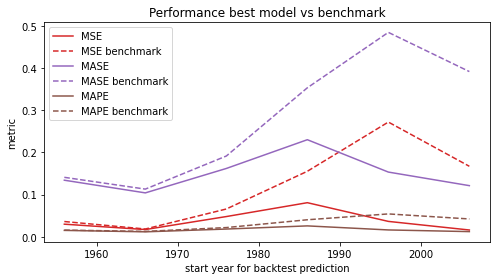

In [50]:
fig, ax = plt.subplots(1, 1, figsize=(7, 4))
ax.plot(performance_comparison["mse"], c="C3", linestyle="-", label="MSE")
ax.plot(
    performance_comparison["mse_benchmark"],
    c="C3",
    linestyle="--",
    label="MSE benchmark",
)
ax.plot(performance_comparison["mase"], c="C4", linestyle="-", label="MASE")
ax.plot(
    performance_comparison["mase_benchmark"],
    c="C4",
    linestyle="--",
    label="MASE benchmark",
)
ax.plot(performance_comparison["mape"], c="C5", linestyle="-", label="MAPE")
ax.plot(
    performance_comparison["mape_benchmark"],
    c="C5",
    linestyle="--",
    label="MAPE benchmark",
)
plt.legend()
ax.set_title("Performance best model vs benchmark")
ax.set_ylabel("metric")
ax.set_xlabel("start year for backtest prediction")
plt.tight_layout()

#### __Conclusion__

[for global temperatures]

Good news! The model performs better than the benchmark on all backtests.

<br>
<br>

## 9. Possible further investigations <a class="anchor" id="future"></a>

[back to top](#toc)

- Compare against performance of other methods 

- Explore seasonality and use SARIMA for forecasting of seasonal trends

In [ ]:
month_vs_year = avg_temp_per_month.pivot_table(
    values=col_name_T,
    index=avg_temp_per_month.index.month,
    columns=avg_temp_per_month.index.year,
)

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
month_vs_year.plot(legend=False, linewidth=0.1, color="k", ax=ax[0])
sns.heatmap(month_vs_year, ax=ax[1])
plt.tight_layout()
plt.show()

In [ ]:
# train Seasonal ARIMA model
mod = SARIMAX(
    avg_temp_per_month[col_name_T],
    order=(3, 2, 3),
    seasonal_order=(1, 1, 0, 12),
    enforce_stationarity=False,
    enforce_invertibility=False,
)
fitted_model = mod.fit()

In [ ]:
# Get forecast
years_to_forecast = 10
forecast_monthly = fitted_model.get_forecast(steps=12 * years_to_forecast)
forecast_monthly_ci = forecast_monthly.conf_int()


In [ ]:
fig, ax = plt.subplots(1, figsize=(10, 5))
ax.plot(forecast_monthly.predicted_mean, color="orange", label="prediction")
ax.fill_between(
    forecast_monthly.row_labels,
    forecast_monthly_ci.iloc[:, 0],
    forecast_monthly_ci.iloc[:, 1],
    color="orange",
    alpha=0.2,
    label="confidence interval",
)
ax.plot(
    avg_temp_per_month[col_name_T][-12 * years_to_forecast :],
    color="green",
    label="observation",
)
ax.set_xlabel("Year")
ax.set_ylabel("average monthly temperature")
ax.set_title("Prediction")
plt.legend()
plt.show()

- Another interesting avenue to explore might be the usage of a SARIMAX model which is able to take in multiple data sources. Exogenous variables such as CO2 levels could be added etc.